# Trabalho 01: Regressão Linear e Polinomial Bayesiana
Andreza Fernandes de Oliveira


Fontes: 
- [Bayesian Linear Regression](http://krasserm.github.io/2019/02/23/bayesian-linear-regression/)

--- 

# Breve explicação

A Regressão Linear Bayesiana busca encontrar uma distribuição de probabilidade que acomode possíveis modelos para representar os dados. Diferente da Regressão Linear tradicional, agora podemos ter vários modelos dentro de um espaço, grosseiramente falando.

Bem, nesse notebook repartimos o processo em **Inferência**, onde encontramos a média e a variância de w, e a parte de **Predição**, onde iremos realizar as nossas predições com o que foi aprendido e realizar os plots solicitados.

Bem, aqui também alinho algumas anotações:

- E, representa o ruído
- Ei, a variancia

- **POSTERIORI**: Distribuição do modelo = p(w | yi...yn)
- **PRIORI**: informação externa = p(w) ~ N(uo, Eo)
- **LIKELIHOOD/VEROSSIMILHANÇA**: Distribuição dos dados = p (yi...yn | w) ~ N (wTx, E)


= p(w | yi...yn) = (p (yi...yn | w) * p(w) ) / somatorio p(y)

=~ p(w | yi...yn) = (p (yi...yn | w) * p(w) )

=~ **p(w | yi...yn) = N(un, En)**

Onde, 
- un = SOM ( Eo * uo + E * xTy)
- En = Eo + ruido*xTx

Daí, na fase de Predição temos que: 
1. p (ŷ | x, w, E)
2. p(w) ~ N(uo, Eo)
3. **p (ŷ | x, uo, Eo, E) = N(uoTx, o2n(x))**

Onde,
- o2n = 1/E + x * En * x

---
### O que muda pra Reg Polinomial?

Basicamente iremos utilizar a função de Design para transformar X e onde tiver X, aplicaremos Φ(X).






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

path = "/content/drive/MyDrive/Acadêmico/UFC/Mestrado/Disciplinas/2020.2/Tópicos Especiais em Lógica II/TRABALHOS/Trabalho 01/"

## 01. Implementação do modelo de Regressão Linear Bayesiana 

Apresente um gráfico contendo os dados e uma representação da distribuição preditiva encontrada.

Esta representação consistirá na curva da média e nas curvas da média mais 2 desvios padrões e média menos 2 desvios padrões.

In [8]:
data_1 = pd.read_csv(path+"linear_regression_data.csv", header=None)
data_1.head(10)

,0,1
0,0.392938,0.086360
1,-0.427721,-0.643872
2,-0.546297,-0.674981
3,0.102630,-0.262892
4,0.438938,0.143177
5,-0.153787,-0.472729
6,0.961528,0.114167
7,0.369659,-0.180323
8,-0.038136,0.011821
9,-0.215765,-0.079865


In [4]:
# Funções de transformação/design do X

# função identidade:    recebe o x e retorna o próprio x
def identity(x):
    return x

# função polinomial:    recebe o x e o grau e retorna um "polinômio" de x 
#                       de acordo com o grau repasso.
# Exemplo: x e grau=3 = [x**1, x**2, x**3]
def polinomial(x, grau=5):
    return np.concatenate([x**g for g in range(1,grau+1)], axis=1)

# adiciona a coluna de 1s no X
def expand(x):
    return np.concatenate([np.ones(x.shape), x], axis=1)

In [5]:
# Funções para Regressão Linear Bayesiana

# Função para parte de inferência:      Recebe X, y
#                                       Retorna un e En
def posteriori_inferencia(X, y, E0, ruido):
    En_inv = E0 * np.eye(X.shape[1]) + ruido * X.T.dot(X) # variancia
    En = np.linalg.inv(En_inv) # variancia
    un = ruido * En.dot(X.T).dot(y) # media
    return un, En

# o2n = 1/E + x * En * x 
def posteriori_predicao(X_test, un, En, ruido):
    y = X_test.dot(un)
    y_variance = 1 / ruido + np.sum(X_test.dot(En) * X_test, axis=1)
    return y, y_variance

In [6]:
from scipy import stats

def plot_data(x, t, label=None):
    plt.scatter(x, t, marker='o', c="k", s=50, label=label)

def plot_valor_esperado(x, y, label=None):
    plt.plot(x, y, 'x', color='r', label=label)

def plot_predictive(x, y, En, std_times=1):
    y = y.ravel()
    En = np.sqrt(En.ravel()) * std_times

    plt.plot(x, y, label="Predição")
    plt.fill_between(x.ravel(), y + En, y - En, alpha = .5, label="Incerteza")

def plot_posterior_samples(x, ys, plot_xy_labels=True):
    plt.plot(x, ys[:, 0], 'r--', alpha=0.5, label='Modelos')
    for i in range(1, ys.shape[1]):
        plt.plot(x, ys[:, i], 'r--', alpha=0.5)

    # if plot_xy_labels:
    #     plt.xlabel('x')
    #     plt.ylabel('y')

def plot_posterior(mean, cov, resolution = 100):
    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))

In [33]:
def apply_bayesian_regression(filename, ruido, E0, design_function=identity, samples_sizes=[1, 3, 5, 10], figsize=(20, 20), poly=False):
    n_experiments = len(samples_sizes)

    plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=.4)
    n_plots = 3

    data = np.loadtxt(filename, delimiter=',')
    data = data[np.argsort(data[:,0])]
    X = data[:,0].reshape(-1,1)
    y = data[:,1].reshape(-1,1)
    X_phi = expand(design_function(X))

    for i, n in enumerate(samples_sizes):
        X_n = X[:n]
        X_phi_n = X_phi[:n]
        y_n = y[:n]
        
        # INFERENCIA: Mean and covariance matrix of posterior
        un, En = posteriori_inferencia(X_phi_n, y_n, E0, ruido)
        
        # PREDICAO: Mean and variances of posterior predictive 
        y, y_var = posteriori_predicao(X_phi, un, En, ruido) #TODO: ver pq ta passando o X TODO
        
        # Draw 5 random weight samples from posterior and compute y values
        w_samples = np.random.multivariate_normal(un.ravel(), En, 5).T
        y_samples = X_phi.dot(w_samples)

        # PLOTS
        if poly == False:
            # plot 01: densidade
            plt.subplot(n_experiments, n_plots, i * n_plots + 1)
            plot_posterior(un, En)
            plt.title(f'Densidade da Posteriori com  (N = {n}) amostras')

        # plot 02: modelos
        plt.subplot(n_experiments, n_plots, i * n_plots + 2)
        plot_valor_esperado(X, y, label="Valor esperado") # valores esperados para a predição
        plot_data(X_n, y_n, label="Dados de treino") # valores utilizados para o treinamento do modelo
        plot_posterior_samples(X, y_samples)
        plt.title(f'Modelos gerados com  (N = {n}) amostras')
        plt.legend()

        plt.subplot(n_experiments, n_plots, i * n_plots + 3)
        plot_valor_esperado(X, y)
        plot_data(X_n, y_n, label="Dados de treino")
        plot_predictive(X, y, np.sqrt(y_var))
        plt.title(f"Variância média: {np.round(np.mean(y_var), 3)} | (N = {n}) amostras ")
        plt.legend()

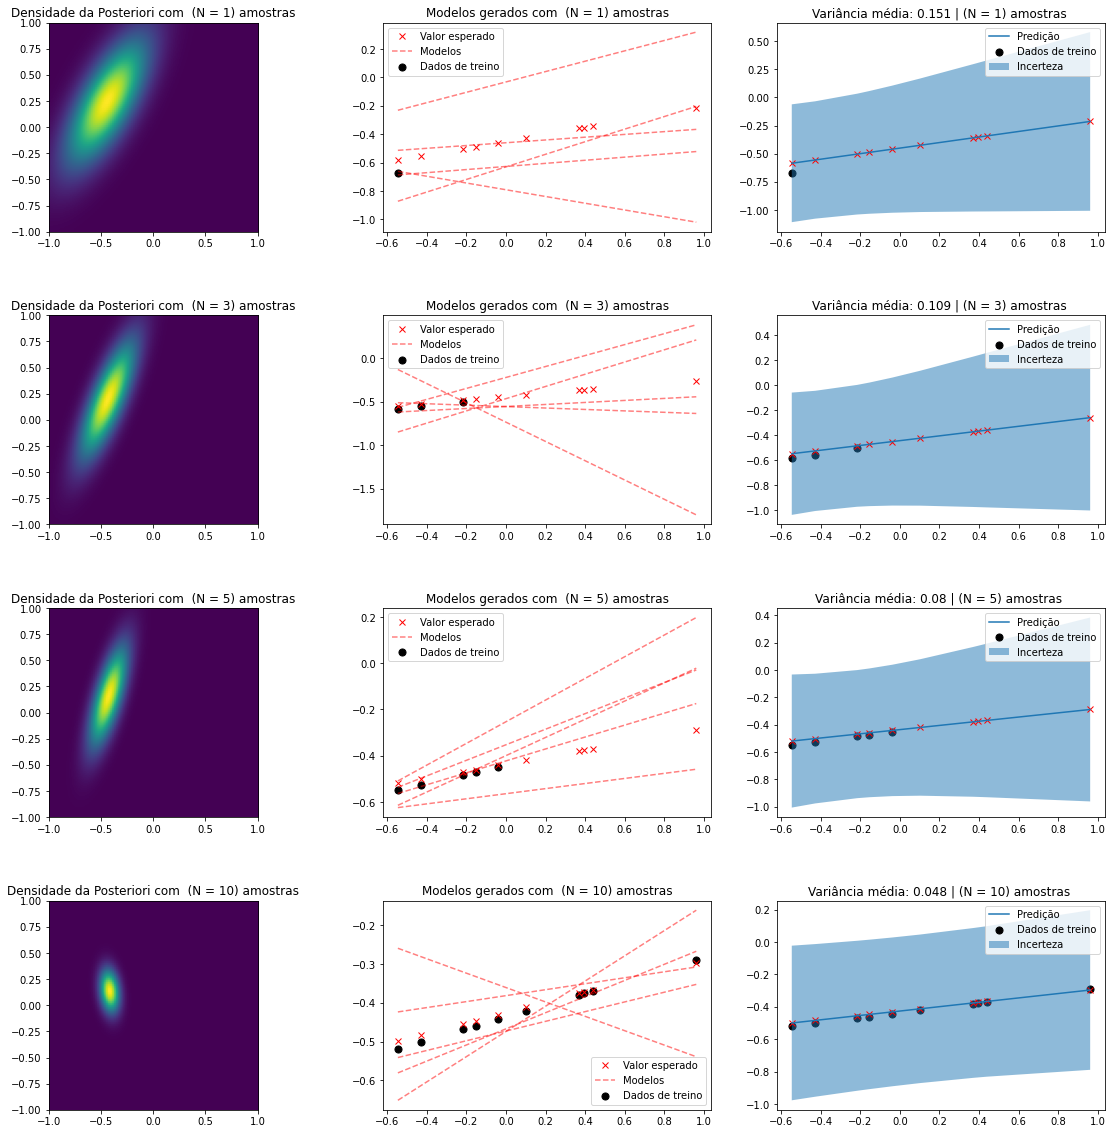

In [34]:
ruido = 25.0
E0 = 5.0

apply_bayesian_regression(path+"linear_regression_data.csv", ruido, E0)

## 02. Implementação do modelo de Regressão Polinomial Bayesiana

Utilize um modelo polinomial de grau 5.

Apresente um gráfico contendo os dados e uma representação da distribuição preditiva encontrada (escolha um metodo de aproximação).

Esta representação consistirá na curva da média e nas curvas da média mais 2 desvios padrões e média menos 2 desvios padrões.

In [35]:
data_2 = pd.read_csv(path+"polynomial_regression_data.csv", header=None)
data_2.head(10)

,0,1
0,0.696469,-0.851271
1,0.286139,0.910864
2,0.226851,0.939731
3,0.551315,-0.323798
4,0.719469,-0.872451
5,0.423106,0.417776
6,0.980764,-0.153078
7,0.684830,-0.949134
8,0.480932,0.281049
9,0.392118,0.787241


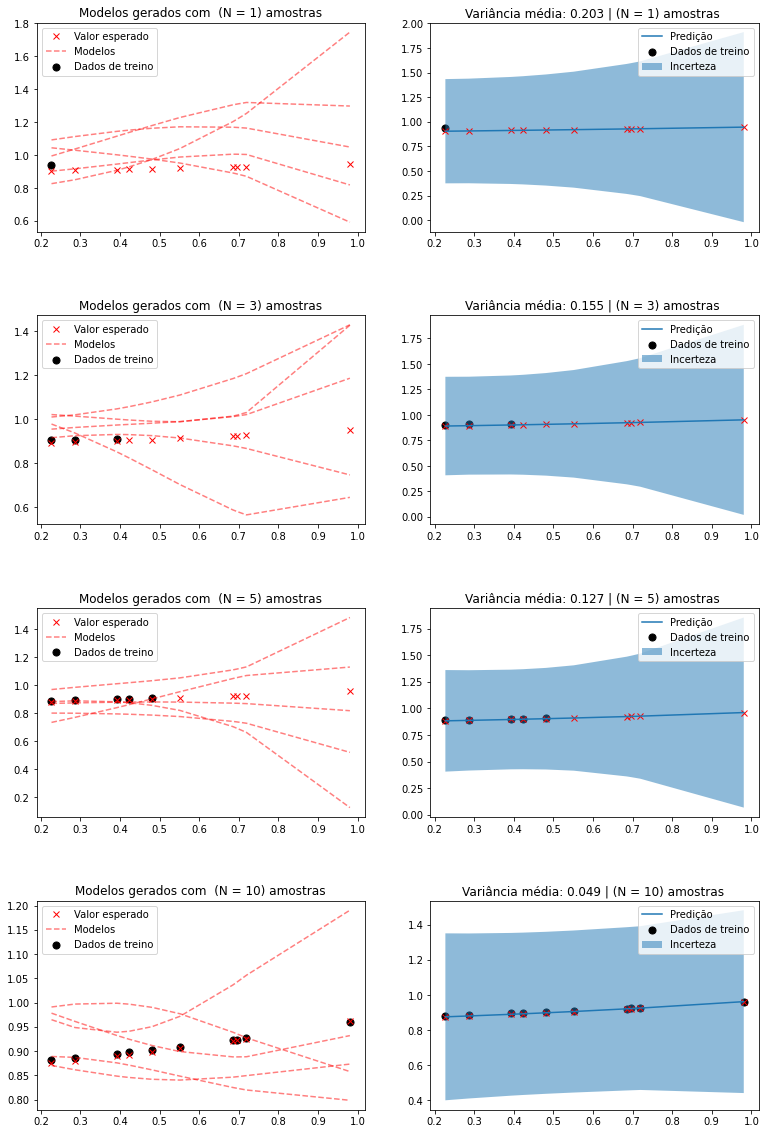

In [36]:
apply_bayesian_regression(path+"polynomial_regression_data.csv", ruido, E0, polinomial, poly=True)